# Cut the stellar light mosaics from UNCOVER DR3 of Abell 2744

Using the coordinates of the convergence map of Price+24 (UNCOVER, v2.0) as a reference


In [1]:
# Import modules
import numpy, os, glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy.io import fits
from astropy import wcs
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from astropy.coordinates import SkyCoord
from reproject import reproject_interp, reproject_adaptive

from master_functions import load_gc_catalogue
from master_classes_for_mapping import GalaxyCluster, StellarLightMap, LensingMap

mpl.rcParams["text.usetex"] = False
mpl.rcParams["font.size"] = 18.0
mpl.rcParams["legend.fontsize"] = 16.0
# mpl.rcParams['savefig.dpi'] = 100

## Define general variables

In [2]:
# 1: create the instance of the Galaxy Cluster class for Abell 2744
# luminosity distance to Abell2744
distance_to_a2744 = 1630 * u.Mpc
# from Harris & Reina-Campos 2023
arcsec_kpc = (
    2100 * u.kpc / (460 * u.arcsec)
)  # conversion between arcsec and kpc at the distance of Abell 2744
# create the instance of the Galaxy Cluster class for Abell 2744
abell2744 = GalaxyCluster(
    "Abell2744", distance=distance_to_a2744, redshift=0.308, arcsec_to_kpc=arcsec_kpc
)

# create the output path
out_path = os.path.join("..", "A2744_UNCOVER_Mosaics_Reduced")
if not os.path.exists(out_path):
    os.makedirs(out_path)

## Create the cutouts and the new headers

In [10]:
# load the convergence map from Price+24
map_price24 = LensingMap("Price24", "lensing map")

# define the list of filters
ls_filters = ["F277W", "F356W", "F444W"]

# convert the edges of the convergence map to celestial coordinates
# convention is such that (0,0) refers to the center of the pixel, not its corner
coords_edges_lambda_map = (
    map_price24.wcs.all_pix2world(
        [
            [-0.5, -0.5],
            [map_price24.wcs.pixel_shape[0] + 0.5, -0.5],
            [-0.5, map_price24.wcs.pixel_shape[1] + 0.5],
            [
                map_price24.wcs.pixel_shape[0] + 0.5,
                map_price24.wcs.pixel_shape[1] + 0.5,
            ],
        ],
        0,
        ra_dec_order=True,
    )
    * u.deg
)

for kind in ["stellar light", "bcg less"]:
    print("Reducing {:s} maps".format(kind))

    # create an average image out of the three filters
    avg_img = 0
    for filter in ls_filters:
        print("Filter: {:s}".format(filter))
        # manually load the stellar light mosaic / or the BCG-less map
        if "light" in kind:  # mosaics
            fname = os.path.join(
                "..",
                "A2744_UNCOVER_Mosaics",
                "abell2744clu-grizli-v7.2-{:s}-clear_drc_sci.fits".format(
                    filter.lower()
                ),
            )
            name_fits = (
                "abell2744clu-grizli-v7.2-{:s}-clear_drc_sci_reduced.fits".format(
                    filter.lower()
                )
            )

        elif "less" in kind:  # BCG-substracted maps
            fname = os.path.join(
                "..",
                "A2744_UNCOVER_Mosaics",
                "uncover_abell2744clu_{:s}_bkg_sci.fits".format(filter.lower()),
            )
            name_fits = "uncover_abell2744clu_{:s}_bkg_sci_reduced.fits".format(
                filter.lower()
            )

        else:
            raise ValueError("kind should be either 'stellar light' or 'bcg less'")
        # open the header and the image
        with fits.open(fname, output_verify="fix") as fits_table:
            stlight_header = fits_table[0].header
            stlight_img = fits_table[
                0
            ].data.T  # transpose the image, it is read as (rows, columns) otherwise
            stlight_wcs = wcs.WCS(stlight_header)

        ### STEP 1: cut out the mosaic to the extent of the convergence map

        # transform the edges of the convergence map from celestial coordinates to pixels
        pixels_edges_lambda_map = stlight_wcs.all_world2pix(
            coords_edges_lambda_map, 0, ra_dec_order=True
        ).astype(int)
        # reduce the mosaics to the extent of the convergence map - always using (x,y) convention
        reduced_img = stlight_img[
            pixels_edges_lambda_map[0, 0] : pixels_edges_lambda_map[3, 0],
            pixels_edges_lambda_map[0, 1] : pixels_edges_lambda_map[3, 1],
        ]
        # correct the dimensions in the header
        reduced_hdr = stlight_header.copy()
        reduced_hdr["CRPIX1"] = stlight_header["CRPIX1"] - pixels_edges_lambda_map[0, 0]
        reduced_hdr["CRPIX2"] = stlight_header["CRPIX2"] - pixels_edges_lambda_map[0, 1]
        reduced_hdr["NAXIS1"] = reduced_img.shape[0]
        reduced_hdr["NAXIS2"] = reduced_img.shape[1]
        reduced_wcs = wcs.WCS(reduced_hdr)

        ### STEP 2: re-bin the image by a factor of 2

        # Define a lower resolution output WCS for the rebinning
        rebinned_hdr = reduced_hdr.copy()
        rebinned_hdr["CD1_1"] = reduced_hdr["CD1_1"] * 2
        rebinned_hdr["CD1_2"] = reduced_hdr["CD1_2"] * 2
        rebinned_hdr["CD2_1"] = reduced_hdr["CD2_1"] * 2
        rebinned_hdr["CD2_2"] = reduced_hdr["CD2_2"] * 2
        rebinned_hdr["CRPIX1"] = reduced_hdr["CRPIX1"] / 2
        rebinned_hdr["CRPIX2"] = reduced_hdr["CRPIX2"] / 2
        rebinned_hdr["NAXIS1"] = reduced_hdr["NAXIS1"] // 2
        rebinned_hdr["NAXIS2"] = reduced_hdr["NAXIS2"] // 2
        rebinned_wcs = wcs.WCS(rebinned_hdr)
        # use the reproject interpolation function to rebin the image
        rebinned_img, _ = reproject_interp(
            (reduced_img, reduced_wcs),
            rebinned_wcs,
            shape_out=(rebinned_hdr["NAXIS1"], rebinned_hdr["NAXIS2"]),
        )

        ### STEP 3: do the averaging amongst the three filters
        avg_img += rebinned_img

    ### STEP 4: offset the fluxes in the observed map to avoid negative values
    # save the average image as a new FITS file
    avg_img /= len(ls_filters)
    mask = avg_img != 0.0
    print("Offseting the fluxes by {:f}".format(numpy.abs(avg_img[mask].min())))
    avg_img[mask] += numpy.abs(avg_img[mask].min())

    primary_hdu = fits.PrimaryHDU(data=avg_img.T, header=rebinned_hdr)
    hdul = fits.HDUList([primary_hdu])
    if "light" in kind:
        name_fits = "abell2744clu-grizli-v7.2-avg-clear_drc_sci_reduced_rebinned.fits"
    elif "less" in kind:
        name_fits = "uncover_abell2744clu_avg_bkg_sci_reduced_rebinned.fits"
    hdul.writeto(os.path.join(out_path, name_fits), overwrite=True)
    print("Saved {:s}".format(name_fits))

 [astropy.io.fits.verify]


Reducing stellar light maps
Filter: F277W
Filter: F356W
Filter: F444W
Offseting the fluxes by 0.090796
Saved abell2744clu-grizli-v7.2-avg-clear_drc_sci_reduced_rebinned.fits
Reducing bcg less maps
Filter: F277W
Filter: F356W
Filter: F444W
Offseting the fluxes by 6.990141
Saved uncover_abell2744clu_avg_bkg_sci_reduced_rebinned.fits


## Validation figures

### Histogram of the values of the images

Reducing stellar light maps
avg _reduced [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Filter: avg_reduced, min: 3.55e-04, max: 1.72e+02, median 9.08e-02
avg _reduced_rebinned [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Filter: avg_reduced_rebinned, min: 3.15e-03, max: 1.47e+02, median 8.80e-02
Reducing bcg less maps
avg _reduced [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Filter: avg_reduced, min: 2.79e+00, max: 1.54e+02, median 1.02e+01
avg _reduced_rebinned [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Filter: avg_reduced_rebinned, min: 8.13e-01, max: 1.33e+02, median 6.99e+00


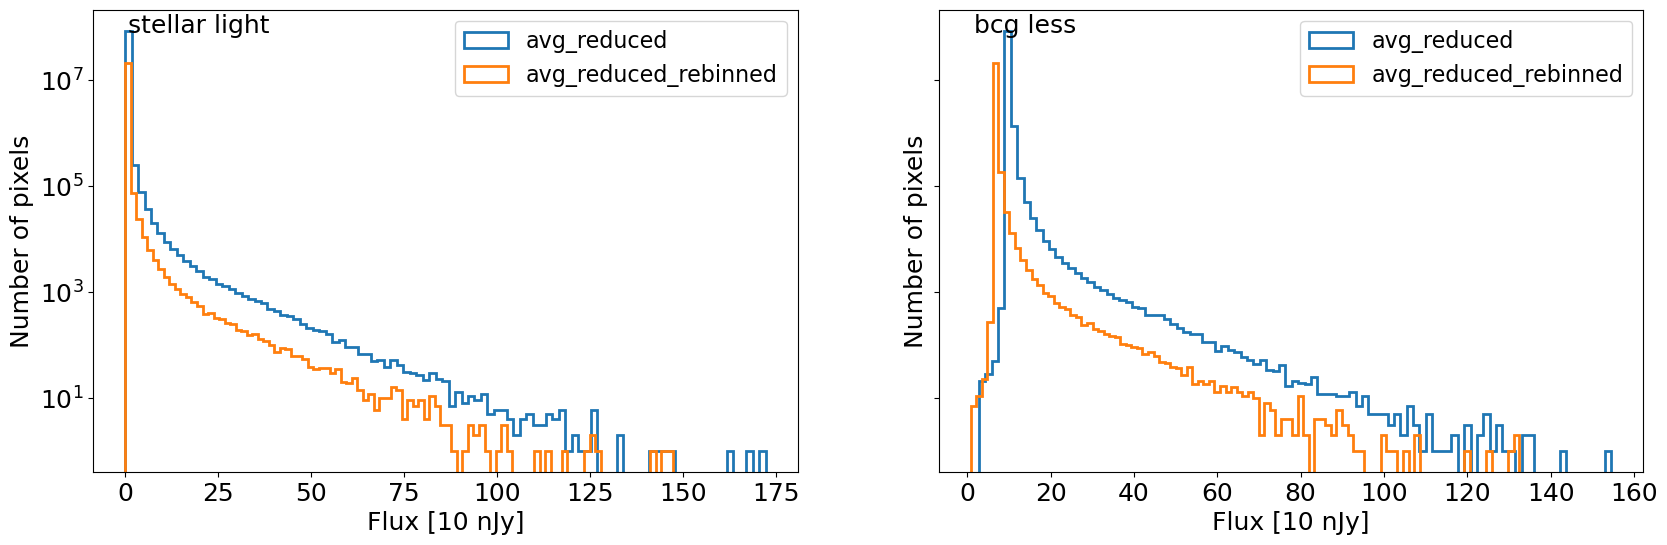

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axs = numpy.atleast_1d(axs)
axs = axs.ravel()

for j, kind in enumerate(["stellar light", "bcg less"]):
    print("Reducing {:s} maps".format(kind))

    for i, filter in enumerate(["avg"]):  # ["F277W", "F356W", "F444W", "avg"]):
        for treatment in ["_reduced", "_reduced_rebinned"]:
            if "light" in kind:
                fname = os.path.join(
                    out_path,
                    f"abell2744clu-grizli-v7.2-{filter.lower()}-clear_drc_sci{treatment}.fits",
                )
            elif "less" in kind:
                fname = os.path.join(
                    out_path,
                    f"uncover_abell2744clu_{filter.lower()}_bkg_sci{treatment}.fits",
                )
            else:
                raise ValueError("kind should be either 'stellar light' or 'bcg less'")
            # open the header and the image
            with fits.open(fname, output_verify="fix") as fits_table:
                stlight_header = fits_table[0].header
                stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)

            print(filter, treatment, stlight_img[0, -10:])
            # plot the reduced image
            mask = stlight_img != 0.0
            minx = numpy.percentile(stlight_img[mask].flatten(), 0)
            maxx = numpy.percentile(stlight_img[mask].flatten(), 100)

            cb = axs[j].hist(
                stlight_img[mask].flatten(),
                label=f"{filter}{treatment}",
                bins=numpy.linspace(minx, maxx, 100),
                histtype="step",
                lw=2,
            )
            print(
                "Filter: {:s}{:s}, min: {:.2e}, max: {:.2e}, median {:.2e}".format(
                    filter, treatment, minx, maxx, numpy.median(stlight_img.flatten())
                )
            )

    # axs[j].axvline(1e-5, color = "black", ls = "--")
    axs[j].annotate(kind, xy=(0.05, 0.95), xycoords="axes fraction")
    axs[j].set_yscale("log")
    axs[j].set_xlabel("Flux [10 nJy]")
    axs[j].set_ylabel("Number of pixels")
    axs[j].legend(loc="upper right")
plt.show()

### Histogram of the values in the rebinned maps

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axs = numpy.atleast_1d(axs)
axs = axs.ravel()

for j, kind in enumerate(["stellar light", "bcg less"]):
    print("Rebinning {:s} maps".format(kind))

    if "light" in kind:
        fnames = glob.glob(
            os.path.join(
                out_path,
                "abell2744clu-grizli-v7.2-*clear_drc_sci_reduced_rebinned.fits",
            )
        )
    elif "less" in kind:
        fnames = glob.glob(
            os.path.join(
                out_path, "uncover_abell2744clu_*_bkg_sci_reduced_rebinned.fits"
            )
        )
    else:
        raise ValueError("kind should be either 'stellar light' or 'bcg less'")

    for i, filter in enumerate(["avg"]):  # ["F277W", "F356W", "F444W", "avg"]):
        # open the header and the image
        with fits.open(fnames[i], output_verify="fix") as fits_table:
            stlight_header = fits_table[0].header
            stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)

        # plot the reduced image
        mask = stlight_img != 0.0
        minx = numpy.percentile(stlight_img[mask].flatten(), 0)
        maxx = numpy.percentile(stlight_img[mask].flatten(), 100)

        cb = axs[j].hist(
            stlight_img[mask].flatten(),
            label=filter,
            bins=numpy.linspace(minx, maxx, 100),
            histtype="step",
            lw=2,
        )
        print(
            "Filter: {:s}, min: {:.2e}, max: {:.2e}, median {:.2e}".format(
                filter, minx, maxx, numpy.median(stlight_img.flatten())
            )
        )

    # axs[j].axvline(1e-5, color = "black", ls = "--")
    axs[j].annotate(kind, xy=(0.05, 0.95), xycoords="axes fraction")
    axs[j].set_yscale("log")
    axs[j].set_xlabel("Flux [10 nJy]")
    axs[j].set_ylabel("Number of pixels")
    axs[j].legend(loc="upper right")
plt.show()

### Pixels with negative flux


Reducing bcg less maps


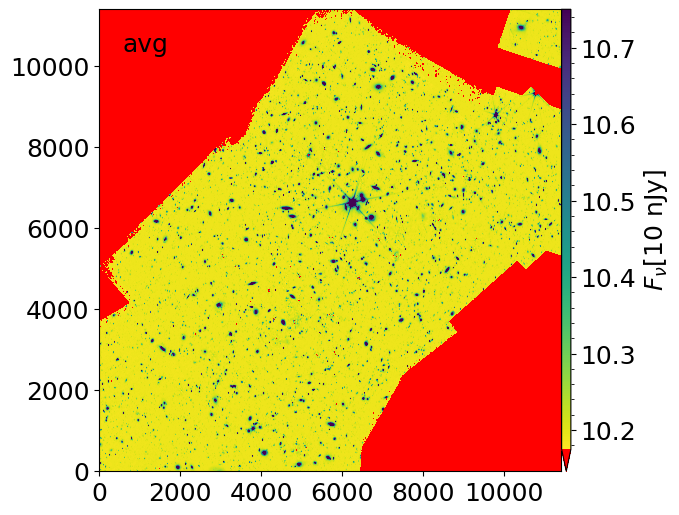

Reducing stellar light maps


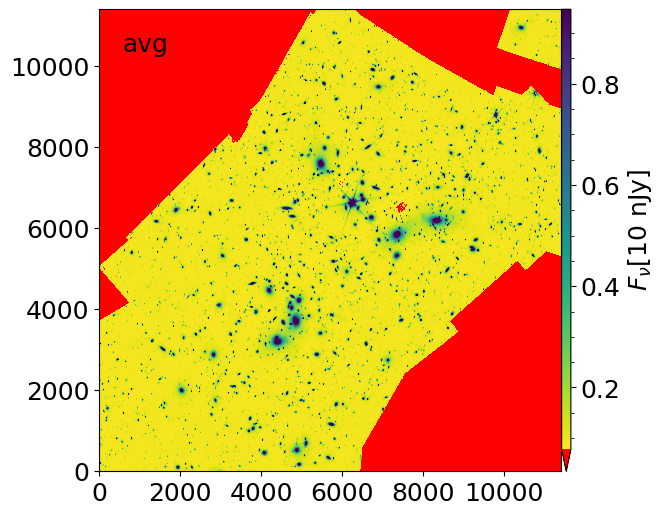

In [4]:
for kind in ["bcg less", "stellar light"]:
    print("Reducing {:s} maps".format(kind))

    fig, axs = plt.subplots(1, figsize=(20, 6), sharex=True, sharey=True)
    axs = numpy.atleast_1d(axs)
    axs = axs.ravel()

    cmap = plt.cm.viridis_r
    cmap.set_under("red")  # set the color for values below the minimum
    for i, filter in enumerate(["avg"]):
        if "light" in kind:
            fname = os.path.join(
                out_path,
                f"abell2744clu-grizli-v7.2-{filter.lower()}-clear_drc_sci_reduced.fits",
            )
        elif "less" in kind:
            fname = os.path.join(
                out_path, f"uncover_abell2744clu_{filter.lower()}_bkg_sci_reduced.fits"
            )
        else:
            raise ValueError("kind should be either 'stellar light' or 'bcg less'")
        # open the header and the image
        with fits.open(fname, output_verify="fix") as fits_table:
            stlight_header = fits_table[0].header
            stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)

        # plot the reduced image
        mask = stlight_img != 0.0
        minx = numpy.percentile(stlight_img[mask].flatten(), 1)
        maxx = numpy.percentile(stlight_img[mask].flatten(), 99)
        norm = Normalize(vmin=minx, vmax=maxx)

        cb = axs[i].imshow(stlight_img.T, origin="lower", cmap=cmap, norm=norm)
        axs[i].annotate(filter, xy=(0.05, 0.95), va="top", xycoords="axes fraction")

    # add the colorbar
    cax = axs[-1].inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
    # create the colorbar object
    cbar = fig.colorbar(cb, cax=cax, ax=axs[-1], extend="min")
    cbar.minorticks_on()  # add minorticks
    cbar.set_label(r"$F_{\nu} [10~{\rm nJy}]$")  # add label

    plt.show()

### Cutouts of the mosaics / BCGless maps for each filter

In [ ]:
for kind in ["stellar light", "bcg less"]:
    print("Reducing {:s} maps".format(kind))

    fig, axs = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)
    axs = numpy.atleast_1d(axs)
    axs = axs.ravel()

    for i, filter in enumerate(["F277W", "F356W", "F444W", "avg"]):
        if "light" in kind:
            fname = os.path.join(
                out_path,
                f"abell2744clu-grizli-v7.2-{filter.lower()}-clear_drc_sci_reduced.fits",
            )
        elif "less" in kind:
            fname = os.path.join(
                out_path, f"uncover_abell2744clu_{filter.lower()}_bkg_sci_reduced.fits"
            )
        else:
            raise ValueError("kind should be either 'stellar light' or 'bcg less'")

        # open the header and the image
        with fits.open(fname, output_verify="fix") as fits_table:
            stlight_header = fits_table[0].header
            stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)

        # plot the reduced image
        cmap = plt.cm.Greys
        cmap.set_under("red")
        mask = stlight_img.T != 0.0
        img = stlight_img.T / numpy.median(stlight_img)
        minx = numpy.percentile(img[mask], 1)
        maxx = numpy.percentile(img[mask], 99)
        cb = axs[i].imshow(
            img, origin="lower", cmap=cmap, norm=LogNorm(vmin=minx, vmax=maxx)
        )
        axs[i].annotate(filter, xy=(0.05, 0.95), va="top", xycoords="axes fraction")

    # add the colorbar
    cax = axs[-1].inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
    # create the colorbar object
    cbar = fig.colorbar(cb, cax=cax, ax=axs[-1], extend="both")
    cbar.minorticks_on()  # add minorticks
    cbar.set_label(r"$F_{\nu} [10~{\rm nJy}]$")  # add label

    plt.show()

### Compare to Price+24

In [ ]:
fig = plt.figure(figsize=(10, 18))
axs = []
left = 0.1
right = 0.87
top = 0.98
bottom = 0.1
hspace = 0.2
wspace = 0.3

# convergence map from Price+24
ax = fig.add_subplot(3, 1, 1, projection=map_price24.wcs)
axs.append(ax)
map_price24.convert_to_projected_mass(abell2744)
cb = ax.imshow(
    map_price24.img_mass.value.T,
    origin="lower",
    transform=ax.get_transform(map_price24.wcs),
    cmap="magma",
    norm=LogNorm(vmin=1e8, vmax=1e10),
)
ax.annotate("Projected mass", xy=(0.05, 0.95), xycoords="axes fraction", color="white")
# add the colorbar
cax = ax.inset_axes([1.02, 0.0, 0.04, 1.0])  # [x0, y0, width, height]
# create the colorbar object
cbar = fig.colorbar(cb, cax=cax, ax=axs[-1])
cbar.minorticks_on()  # add minorticks
cbar.set_label(r"$\Sigma~[\rm M_{\odot}/kpc^2]$")  # add label

for i, kind in enumerate(["stellar light", "bcg less"]):
    print("Adding {:s} maps".format(kind))

    if "light" in kind:
        fname = os.path.join(
            out_path, "abell2744clu-grizli-v7.2-avg-clear_drc_sci_reduced_rebinned.fits"
        )
    elif "less" in kind:
        fname = os.path.join(
            out_path, "uncover_abell2744clu_avg_bkg_sci_reduced_rebinned.fits"
        )

    with fits.open(fname, output_verify="fix") as fits_table:
        stlight_header = fits_table[0].header
        stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)
        stlight_wcs = wcs.WCS(stlight_header)

    # plot the reduced image
    ax = fig.add_subplot(3, 1, 2 + i, projection=stlight_wcs)
    axs.append(ax)
    cmap = plt.cm.Greys
    cmap.set_under("red")
    mask = stlight_img.T != 0.0
    img = stlight_img.T / numpy.median(stlight_img)
    minx = numpy.percentile(img[mask], 1)
    maxx = numpy.percentile(img[mask], 99)
    cb = ax.imshow(img, origin="lower", cmap=cmap, norm=LogNorm(vmin=minx, vmax=maxx))
    ax.annotate(kind, xy=(0.05, 0.95), xycoords="axes fraction")

# add the colorbar
cax = axs[-1].inset_axes([1.001, 0.0, 0.02, 2.0])  # [x0, y0, width, height]
# create the colorbar object
cbar = fig.colorbar(cb, cax=cax, ax=axs[-1], extend="min")
cbar.minorticks_on()  # add minorticks
cbar.set_label(r"$F_{\nu}/F_{\nu, \rm median}$")  # add label

# format all axes
for j, ax in enumerate(axs):
    ax.set_xlabel("")
    ra = ax.coords[0]
    dec = ax.coords[1]
    # if j == 0:
    dec.set_axislabel("Declination (J2000)")
    # else:
    dec.set_ticks_visible(True)
    dec.set_ticklabel_visible(True)
    #  dec.set_axislabel('')

    ra.set_axislabel("Right Ascension (J2000)")

    # set the formatting of the axes
    ra.set_major_formatter("hh:mm:ss.s")
    dec.set_major_formatter("dd:mm")

    # display minor ticks
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ra.set_minor_frequency(10)
    dec.set_minor_frequency(10)

fig.subplots_adjust(
    left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
)
plt.show()

### Comparison before / after re-binning for the average maps

_reduced (11406, 11404) 0.0 172.28903
_reduced 4757.0 4006.0
_reduced 11406 11404
_reduced 1.0 1.0
_reduced 3.5875 -30.3966667
_reduced RA---TAN DEC--TAN
_reduced -1.1111111111111e-05 0.0
_reduced 0.0 1.1111111111111e-05
avg _reduced 0.07801111787557602 0.9467876577377297 0.09084614 42557886
_reduced_rebinned (5703, 5702) 0.0 147.24648171663284
_reduced_rebinned 2378.5 2003.0
_reduced_rebinned 5703 5702
_reduced_rebinned 1.0 1.0
_reduced_rebinned 3.5875 -30.3966667
_reduced_rebinned RA---TAN DEC--TAN
_reduced_rebinned -2.2222222222222e-05 0.0
_reduced_rebinned 0.0 2.2222222222222e-05
avg _reduced_rebinned 0.07515382343903183 0.9434512056907097 0.08799566215990733 10629908


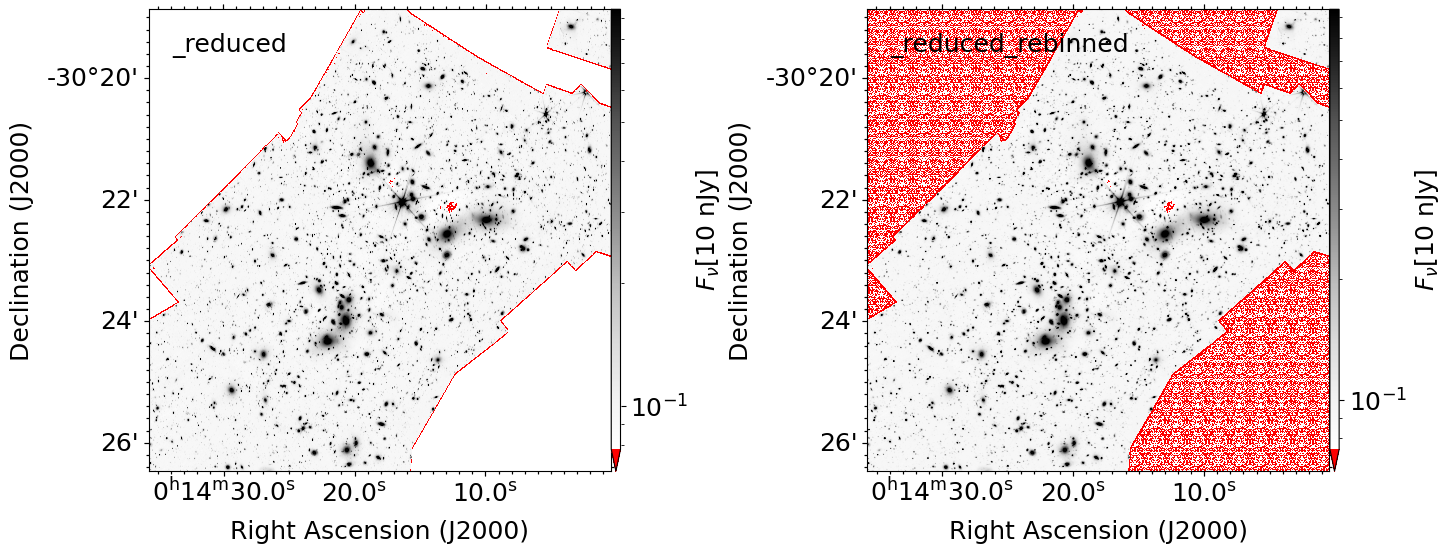

_reduced (11406, 11404) 0.0 154.4972
_reduced 4757.0 4006.0
_reduced 11406 11404
_reduced 1.0 1.0
_reduced 3.5875 -30.3966667
_reduced RA---TAN DEC--TAN
_reduced -1.1111111111111e-05 0.0
_reduced 0.0 1.1111111111111e-05
avg _reduced 10.174901962280273 10.750273017883302 10.188121 42557887
_reduced_rebinned (5703, 5702) 0.0 132.50546352068585
_reduced_rebinned 2378.5 2003.0
_reduced_rebinned 5703 5702
_reduced_rebinned 1.0 1.0
_reduced_rebinned 3.5875 -30.3966667
_reduced_rebinned RA---TAN DEC--TAN
_reduced_rebinned -2.2222222222222e-05 0.0
_reduced_rebinned 0.0 2.2222222222222e-05
avg _reduced_rebinned 6.975098169920966 7.549956295291587 6.988323013504365 10629908


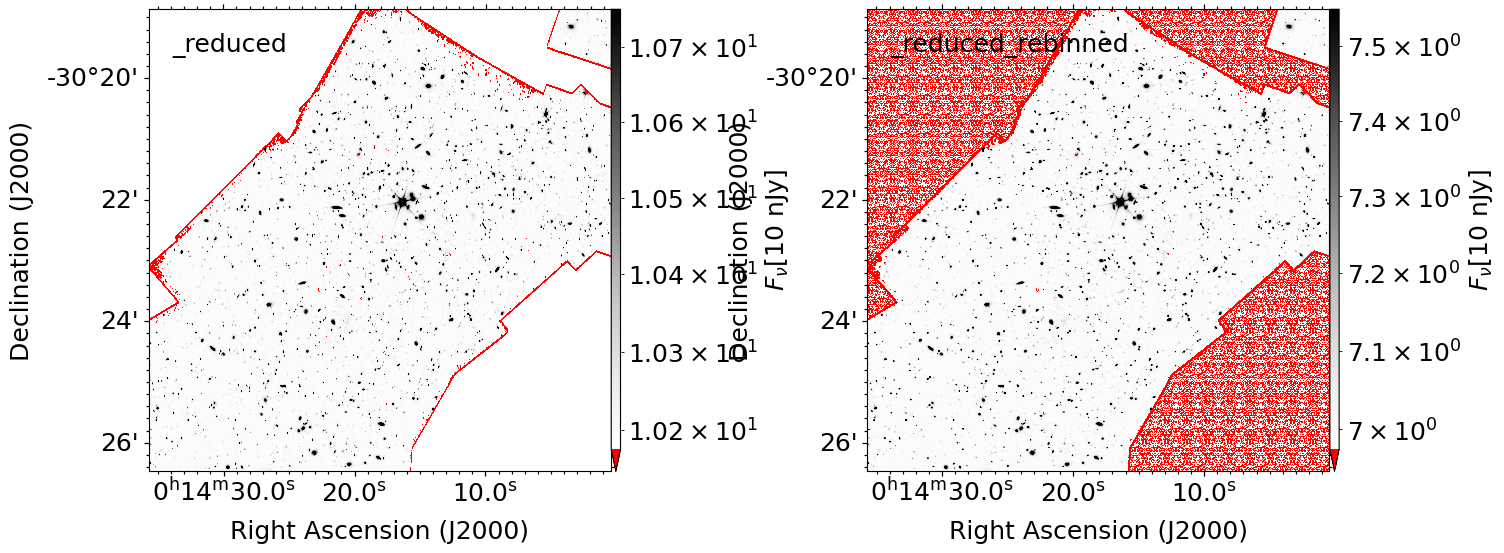

In [12]:
for kind in ["stellar light", "bcg less"]:
    fig = plt.figure(figsize=(17, 6))
    axs = []
    filter = "avg"
    for i, treatment in enumerate(["_reduced", "_reduced_rebinned"]):
        if "light" in kind:
            fname = os.path.join(
                out_path,
                f"abell2744clu-grizli-v7.2-{filter.lower()}-clear_drc_sci{treatment}.fits",
            )
        elif "less" in kind:
            fname = os.path.join(
                out_path,
                f"uncover_abell2744clu_{filter.lower()}_bkg_sci{treatment}.fits",
            )
        else:
            raise ValueError("kind should be either 'stellar light' or 'bcg less'")

        # open the header and the image
        with fits.open(fname, output_verify="fix") as fits_table:
            stlight_header = fits_table[0].header
            stlight_img = fits_table[0].data.T  # otherwise read as (rows, columns)
            stlight_wcs = wcs.WCS(stlight_header)

        print(treatment, stlight_img.shape, stlight_img.min(), stlight_img.max())
        print(treatment, stlight_header["CRPIX1"], stlight_header["CRPIX2"])
        print(treatment, stlight_header["NAXIS1"], stlight_header["NAXIS2"])
        print(treatment, stlight_header["CDELT1"], stlight_header["CDELT2"])
        print(treatment, stlight_header["CRVAL1"], stlight_header["CRVAL2"])
        print(treatment, stlight_header["CTYPE1"], stlight_header["CTYPE2"])
        print(treatment, stlight_header["CD1_1"], stlight_header["CD1_2"])
        print(treatment, stlight_header["CD2_1"], stlight_header["CD2_2"])

        ax = fig.add_subplot(1, 2, i + 1, projection=stlight_wcs)
        axs.append(ax)
        # plot the reduced image
        cmap = plt.cm.Greys
        cmap.set_under("red")
        mask = stlight_img.T != 0.0
        img = stlight_img.T  # /numpy.median(stlight_img)

        minx = numpy.percentile(img[mask], 1)
        maxx = numpy.percentile(img[mask], 99)
        print(
            filter, treatment, minx, maxx, numpy.median(stlight_img), numpy.sum(~mask)
        )
        cb = ax.imshow(
            img, origin="lower", cmap=cmap, norm=LogNorm(vmin=minx, vmax=maxx)
        )
        ax.annotate(treatment, xy=(0.05, 0.95), va="top", xycoords="axes fraction")

        # add the colorbar
        cax = ax.inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
        # create the colorbar object
        cbar = fig.colorbar(cb, cax=cax, ax=ax, extend="min")
        cbar.minorticks_on()  # add minorticks
        cbar.set_label(r"$F_{\nu} [10~\rm nJy]$")  # add label

    # format all axes
    for j, ax in enumerate(axs):
        ax.set_xlabel("")
        ra = ax.coords[0]
        dec = ax.coords[1]
        dec.set_axislabel("Declination (J2000)")
        ra.set_axislabel("Right Ascension (J2000)")

        # set the formatting of the axes
        ra.set_major_formatter("hh:mm:ss.s")
        dec.set_major_formatter("dd:mm")

        # display minor ticks
        ra.display_minor_ticks(True)
        dec.display_minor_ticks(True)
        ra.set_minor_frequency(10)
        dec.set_minor_frequency(10)

    plt.show()

## Re-binning of the maps

(256, 256) (128, 128) (128, 128) (128, 128)


Text(0.5, 1.0, 'reproject_adaptive\nGaussian kernel')

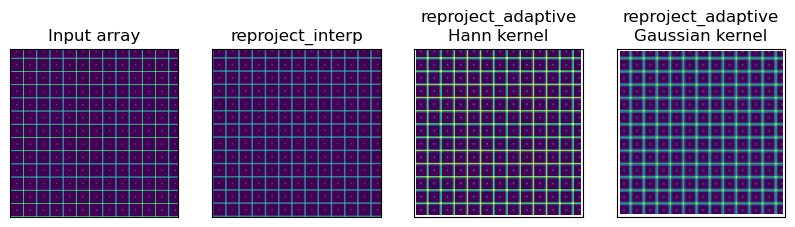

In [2]:
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from reproject import reproject_interp, reproject_adaptive

# Set up initial array with pattern
input_array = np.zeros((256, 256))
input_array[::20, :] = 1
input_array[:, ::20] = 1
input_array[10::20, 10::20] = 1

# Define a simple input WCS
input_wcs = WCS(naxis=2)
input_wcs.wcs.crpix = 128.5, 128.5
input_wcs.wcs.cdelt = -0.01, 0.01

# Define a lower resolution output WCS with rotation
output_wcs = WCS(naxis=2)
output_wcs.wcs.crpix = 64.5, 64.5
output_wcs.wcs.cdelt = -0.02, 0.02

# Reproject using interpolation and adaptive resampling
result_interp, _ = reproject_interp(
    (input_array, input_wcs), output_wcs, shape_out=(128, 128)
)
result_hann, _ = reproject_adaptive(
    (input_array, input_wcs), output_wcs, shape_out=(128, 128), kernel="hann"
)
result_gaussian, _ = reproject_adaptive(
    (input_array, input_wcs), output_wcs, shape_out=(128, 128), kernel="gaussian"
)
print(input_array.shape, result_interp.shape, result_hann.shape, result_gaussian.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(input_array, origin="lower", vmin=0, vmax=1, interpolation="hanning")
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title("Input array")
plt.subplot(1, 4, 2)
plt.imshow(result_interp, origin="lower", vmin=0, vmax=1)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title("reproject_interp")
plt.subplot(1, 4, 3)
plt.imshow(result_hann, origin="lower", vmin=0, vmax=0.5)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title("reproject_adaptive\nHann kernel")
plt.subplot(1, 4, 4)
plt.imshow(result_gaussian, origin="lower", vmin=0, vmax=0.5)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title("reproject_adaptive\nGaussian kernel")